In [ ]:
# ! pip install pymongo


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [56]:
from mongo import MongoDBManager
import os
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np

# Retrieving data

In [3]:
load_dotenv()
uri = os.getenv('MONGODB_URI')
database_name = os.getenv('DATABASE_NAME')
mongo_manager = MongoDBManager(uri, database_name)

In [4]:
documents = mongo_manager.read_all_documents_in_collection_with_GridFS()

In [5]:
def data_recurcive_length(data):
    total = 0
    try:
        for key in data.keys():
            for profession in data[key].keys():
                for language in data[key][profession].keys():
                    print(f"{key} - {profession} - {language} : {len(data[key][profession][language])}")
                    total += len(data[key][profession][language])
        print(f"Total: {total}")
    except Exception as e:
        print(e)
        print(data[key][profession])

In [6]:
data_recurcive_length(documents)

US - Accompagnatrice spirituelle ou accompagnateur spirituel - en : 68
US - Accompagnatrice spirituelle ou accompagnateur spirituel - fr : 18
US - Accompagnatrice, accompagnateur, musicienne ou musicien dans de petits ensembles - fr : 27
US - Accompagnatrice, accompagnateur, musicienne ou musicien dans de petits ensembles - en : 2723
US - Actuaire - en : 108
US - Adjointe ou adjoint à la recherche - en : 236
US - Administratrice ou administrateur - fr : 8
US - Administratrice ou administrateur - en : 1678
US - Administratrice ou administrateur de contrats - fr : 25
US - Administratrice ou administrateur de contrats - en : 522
US - Administratrice ou administrateur de programmes de développement durable - fr : 12
US - Administratrice ou administrateur de programmes de développement durable - en : 1024
US - Administratrice ou administrateur de prêts commerciaux - fr : 51
US - Administratrice ou administrateur de prêts commerciaux - en : 999
US - Agent ou agente d’approvisionnement et de 

# Formating Datas

In [7]:
def data_to_sql_format(data):
    data_formated = []
    for country in documents.keys():
        for profession in documents[country].keys():
            for language in documents[country][profession].keys():
                    for data in documents[country][profession][language]:
                        data['country'] = country
                        data['profession'] = profession
                        data['language'] = language
                        data_formated.append(data)
    return data_formated                    
data_formated=data_to_sql_format(documents)
print(len(data_formated))

37141


In [8]:
import dedupe

def clear_data(data):
    df=pd.DataFrame(data)
    df = df.applymap(lambda x: tuple(x) if isinstance(x, list) else x)
    df=df.drop_duplicates()
    df.describe()
    countries = df["country"].drop_duplicates().to_list()
    professions = df["profession"].drop_duplicates().to_list()
    languages = df["language"].drop_duplicates().to_list()
    clear_data={}
    for country in countries:
        for profession in professions:
            for lang in languages:
                try:
                    if country not in clear_data:
                        clear_data[country] = {}
                    if profession not in clear_data[country]:
                        clear_data[country][profession] = {}
                    
                    filtered_df = df[(df["language"] == lang) & (df["profession"] == profession) & (df["country"] == country)]
                    clear_data[country][profession][lang] = filtered_df.to_dict('records')
                except Exception as e:
                    print(e)
                
    return clear_data

data_cleared = clear_data(data_formated)

C:\Users\PC\AppData\Local\Temp\ipykernel_24460\1776475680.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: tuple(x) if isinstance(x, list) else x)


In [9]:
data_recurcive_length(data_cleared)

US - Accompagnatrice spirituelle ou accompagnateur spirituel - en : 68
US - Accompagnatrice spirituelle ou accompagnateur spirituel - fr : 10
US - Accompagnatrice, accompagnateur, musicienne ou musicien dans de petits ensembles - en : 2723
US - Accompagnatrice, accompagnateur, musicienne ou musicien dans de petits ensembles - fr : 27
US - Actuaire - en : 84
US - Actuaire - fr : 0
US - Adjointe ou adjoint à la recherche - en : 236
US - Adjointe ou adjoint à la recherche - fr : 0
US - Administratrice ou administrateur - en : 1678
US - Administratrice ou administrateur - fr : 8
US - Administratrice ou administrateur de contrats - en : 409
US - Administratrice ou administrateur de contrats - fr : 21
US - Administratrice ou administrateur de programmes de développement durable - en : 1024
US - Administratrice ou administrateur de programmes de développement durable - fr : 12
US - Administratrice ou administrateur de prêts commerciaux - en : 999
US - Administratrice ou administrateur de prêt

# Visualizing Data

In [10]:
df = pd.DataFrame(data_formated)
df.describe()

,positionTitle,companyName,location,salaryInfoAndJobType,description,datePosted,salary,jobType,shiftAndSchedule,jobBenefits,updatedDate,country,profession,language
count,37141,37141,37141,37141,37141,36119,37141,37141,37141,37141,37141,37141,37141,37141
unique,14897,7710,6530,5413,11539,61,3233,322,584,3164,15,3,17,2
top,Office Administrator,,"Montréal, QC",Full-time,,,,[],,[],2024-09-13,Canada,"Agente commerciale ou agent commercial, politi...",en
freq,450,291,924,4084,296,4487,17621,8222,26759,17670,9015,15684,6458,27069


In [11]:
df[df['shiftAndSchedule'] != ''].describe()

,positionTitle,companyName,location,salaryInfoAndJobType,description,datePosted,salary,jobType,shiftAndSchedule,jobBenefits,updatedDate,country,profession,language
count,10382,10382,10382,10382,10382,10071,10382,10382,10382,10382,10382,10382,10382,10382
unique,5546,2772,2569,2209,3377,61,1356,129,583,1603,12,2,17,2
top,Office Administrator,PHSA,"Montréal, QC",Full-time,POSTE AVEC BEAUCOUP DE DÉPLACEMENT\n\nSERVICES...,,,,[Monday to Friday],[],2024-09-13,Canada,Administratrice ou administrateur,en
freq,220,187,278,864,44,1024,3674,1890,1333,3220,3213,6156,1725,8309


In [12]:
df[:5]

,positionTitle,companyName,location,salaryInfoAndJobType,description,datePosted,salary,jobType,shiftAndSchedule,jobBenefits,updatedDate,country,profession,language
0,Overnight Cabin Supervisor-SFO Airport,G2 Secure Staff,"780 South Airport Boulevard, San Francisco, CA...",$31 an hour - Full-time,G2 Secure Staff is expanding and looking to ad...,2024-09-06,,"[an hour , Full]",,"[401(k), 401(k) matching, Dental insurance, Em...",2024-09-09,US,Accompagnatrice spirituelle ou accompagnateur ...,en
1,Chaplain - N/E - New River Valley Medical Center,Carilion Clinic,"2900 Lamb Circle, Christiansburg, VA 24073",,Provides a ministry of spiritual care and emot...,2024-09-09,,[],"[Weekends as needed, Night shift, On call]",[],2024-09-11,US,Accompagnatrice spirituelle ou accompagnateur ...,en
2,Bethany Christian Church Residency - Washingto...,Leadership Pathway,"Washington, IN 47501","$1,000 a month - Full-time",Bethany Christian Church is a growing multi-si...,2024-08-10,"$1,000 a month","[an hour , Full]",,[],2024-09-09,US,Accompagnatrice spirituelle ou accompagnateur ...,en
3,Groups Director/Pastor (Plainfield Campus),Traders Point Christian Church Inc,"2002 Stafford Road, Plainfield, IN 46168",Full-time,CULTURE & SPIRITUAL LEADERSHIP\n\nTraders Poin...,2024-09-09,,[],,[Leadership training provided],2024-09-11,US,Accompagnatrice spirituelle ou accompagnateur ...,en
4,Personal Care Attendant,EveryAge,"Lexington, NC 27292",Full-time,Carolina SeniorCare is a non-profit provider o...,2024-09-09,,[],,[],2024-09-11,US,Accompagnatrice spirituelle ou accompagnateur ...,en


In [13]:
df = df.applymap(lambda x: tuple(x) if isinstance(x, list) else x)
df = df.drop_duplicates()

df = df[((df['positionTitle'] != '') & (df['description'] != '')) | df['positionTitle'] != '']
df["jobType"] = df["jobType"].replace(' () ', '')
"""
df['jobType'] = df.apply(
    lambda x: tuple(list(x['jobType']) + list(x['salary'])) 
    if not re.search(r'\d+', str(x['salary'])) 
    else x['jobType'], 
    axis=1
)
"""
"""
df['salary'] = df['salary'].map(
    lambda x: '' 
    if not re.search(r'\d+', str(x))
    else x
)

df['salary'] = df.apply(
    lambda x: str(x['salary']+"-"+str(list(x['jobType'])[0]) )
    if not re.search(r'\d+', str(list(x['jobType'])[0])) 
    else str(x['salary']), 
    axis=1
)
professions[5:7]

df['jobType'] = df['jobType'].map(
    lambda x: '' 
    if not re.search(r'\d+', str(x))
    else x
)
"""
df.describe()

C:\Users\PC\AppData\Local\Temp\ipykernel_24460\1126720353.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: tuple(x) if isinstance(x, list) else x)


,positionTitle,companyName,location,salaryInfoAndJobType,description,datePosted,salary,jobType,shiftAndSchedule,jobBenefits,updatedDate,country,profession,language
count,36318,36318,36318,36318,36318,35323,36318,36318,36318,36318,36318,36318,36318,36318
unique,14897,7710,6530,5413,11539,61,3233,322,584,3164,15,3,17,2
top,Office Administrator,,"Montréal, QC",Full-time,,,,(),,(),2024-09-13,Canada,"Agente commerciale ou agent commercial, politi...",en
freq,445,270,873,4031,275,4448,17190,8112,26190,17274,8711,15044,6434,26476


In [14]:
for column in df.columns:
    print(column)

positionTitle
companyName
location
salaryInfoAndJobType
description
datePosted
salary
jobType
shiftAndSchedule
jobBenefits
updatedDate
country
profession
language


In [15]:
df[df['positionTitle'].str.contains('rn', case=False)==True]['positionTitle'].tolist()

['Overnight Cabin Supervisor-SFO Airport',
 'Phlebotomist Technician (Morning Shift)',
 'All-Source Intelligence Analyst Journeyman',
 'Direct Support Professional - Overnights',
 'Certified Nursing Assistant (CNA) Afternoons',
 'Instructional Designer (Digital Learning)',
 '10 hr schedule Afternoon/Midnight split Shelter Specialist',
 'Overnight Relief Crisis Intervention Specialist (QMHP)',
 'Resident Coordinator - PRN-Day and Swing Shift',
 'Patient Care RN in the Acute Department',
 'Northern & Western Montana Outreach Specialist (Havre)',
 'Veteran Care Coordinator-RN',
 'Bilingual PRN Early Childhood Instructor',
 'BRONSON BATTLE CREEK LICENSED PRACTICAL NURSE (LPN) PRN VARIABLE HOURS',
 'Horn Teaching Artist - North Side',
 '10 hr schedule Afternoon/Midnight split Shelter Specialist',
 'All-Source Intelligence Analyst Journeyman',
 'Overnight Relief Crisis Intervention Specialist (QMHP)',
 'Direct Support Professional (Part-time Sleep Overnights)',
 'Assistant Director, Graduate

In [16]:
def plot_bar_chart(df, column):
    plt.figure(figsize=(10, 6))
    for i in range(0 , df[column].nunique() , 20):
        df[column].value_counts()[i:i+20].plot(kind='bar')
        plt.show()

In [17]:
# from pandasql import sqldf

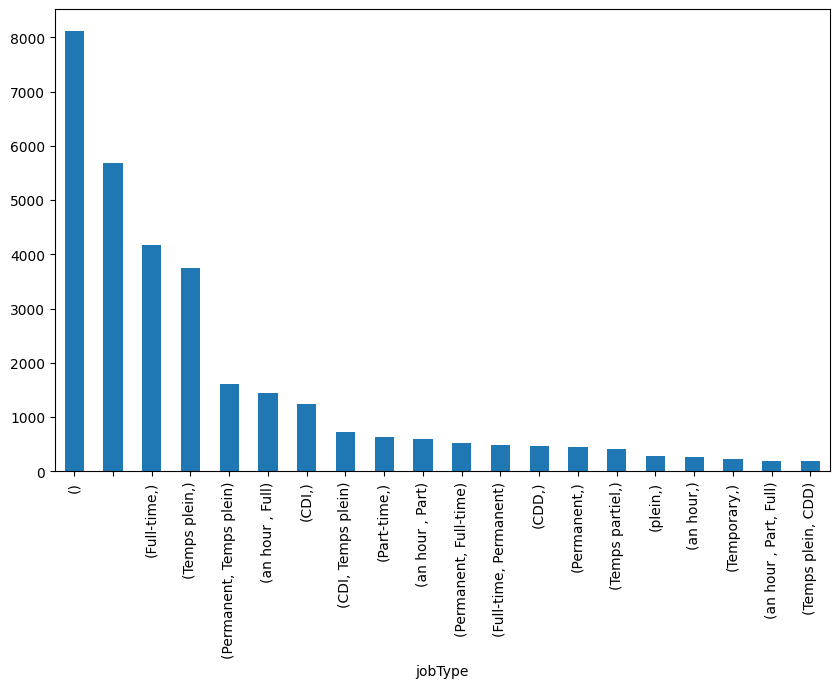

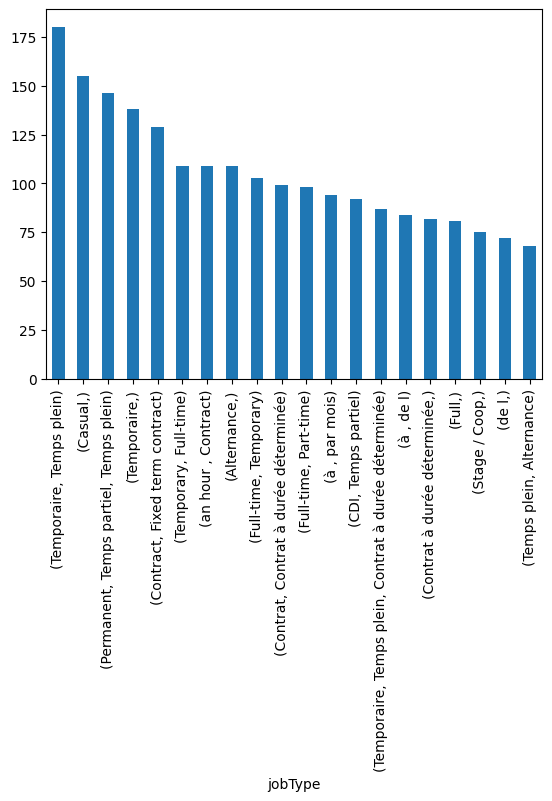

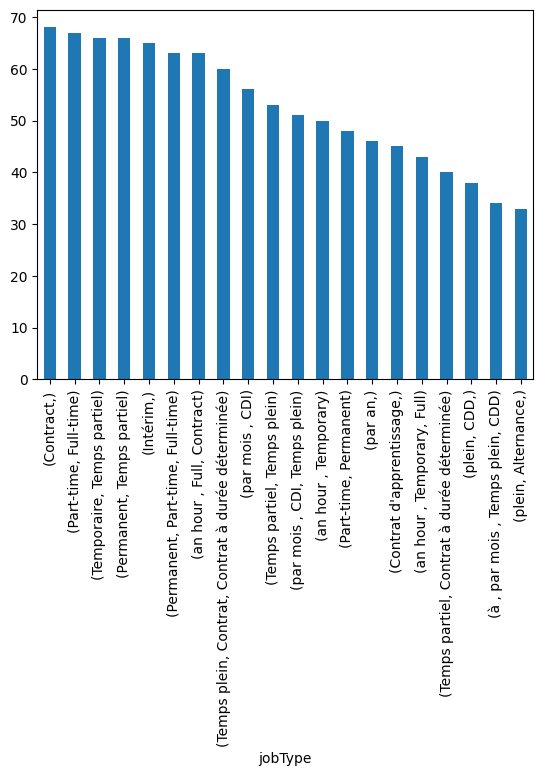

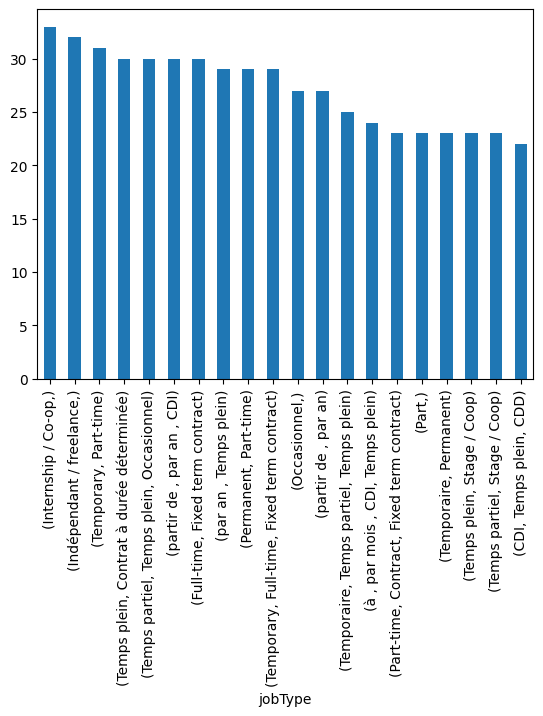

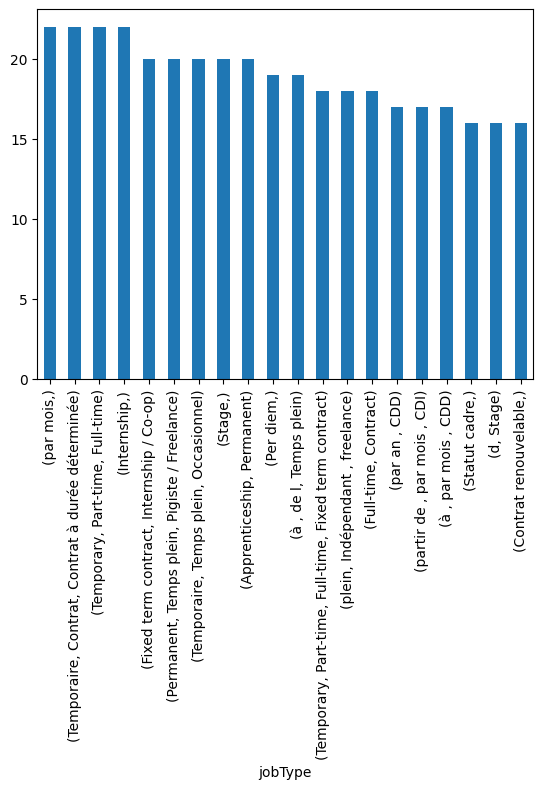

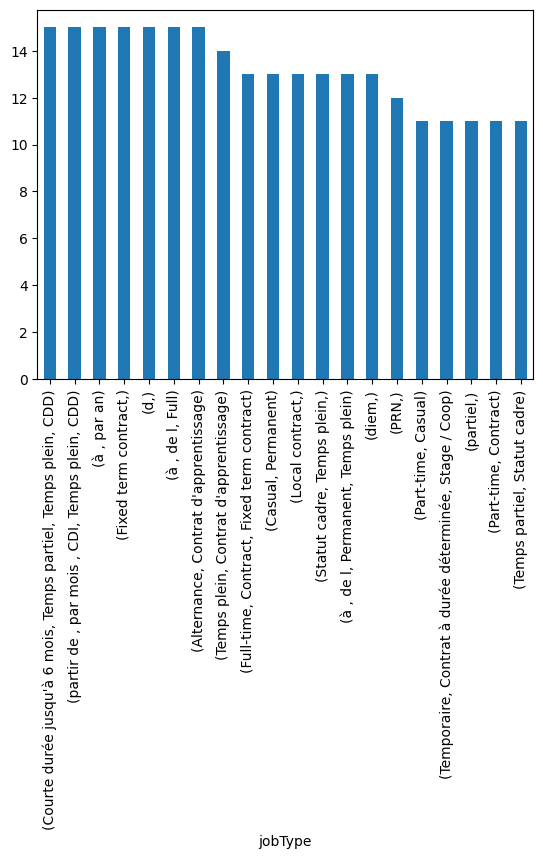

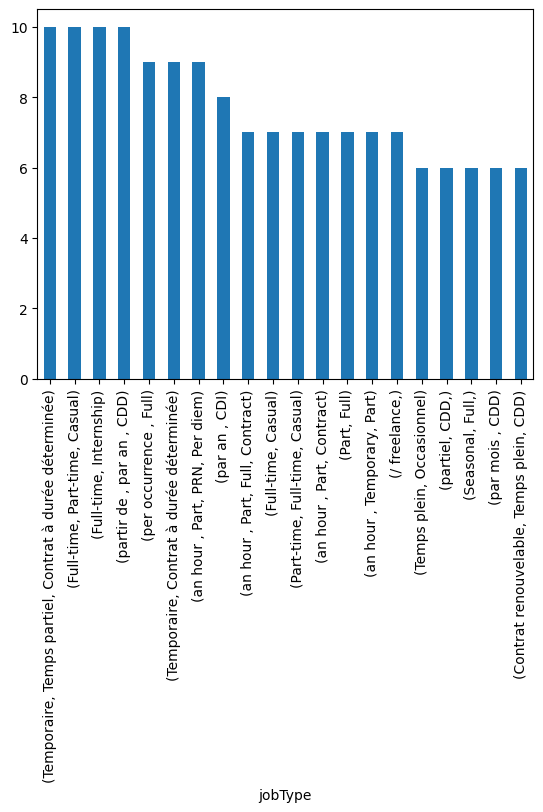

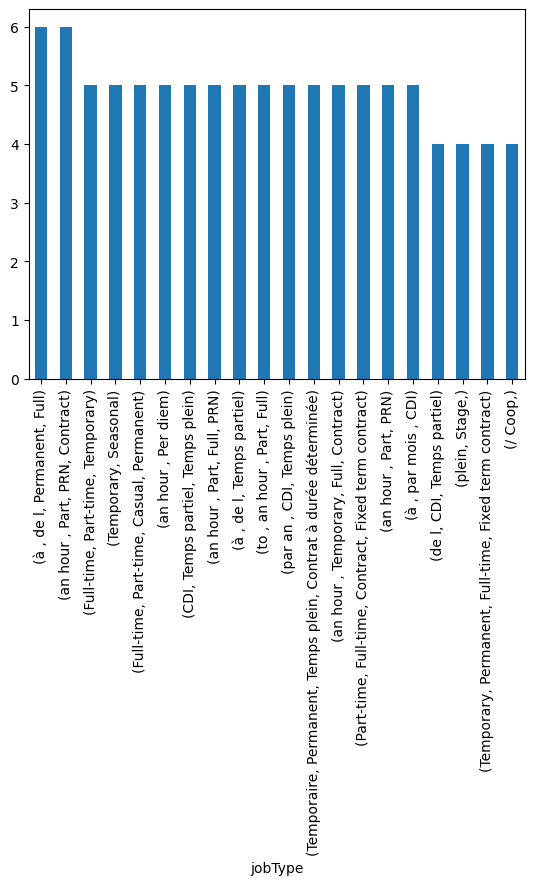

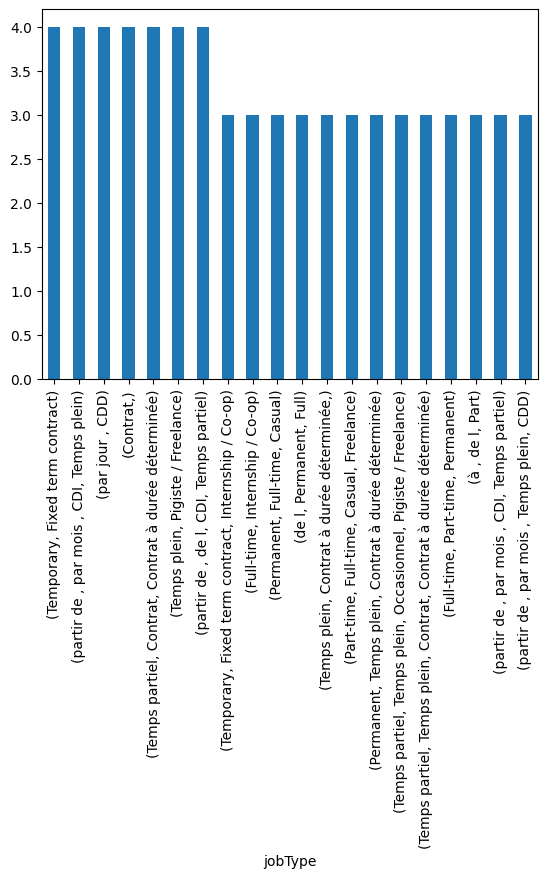

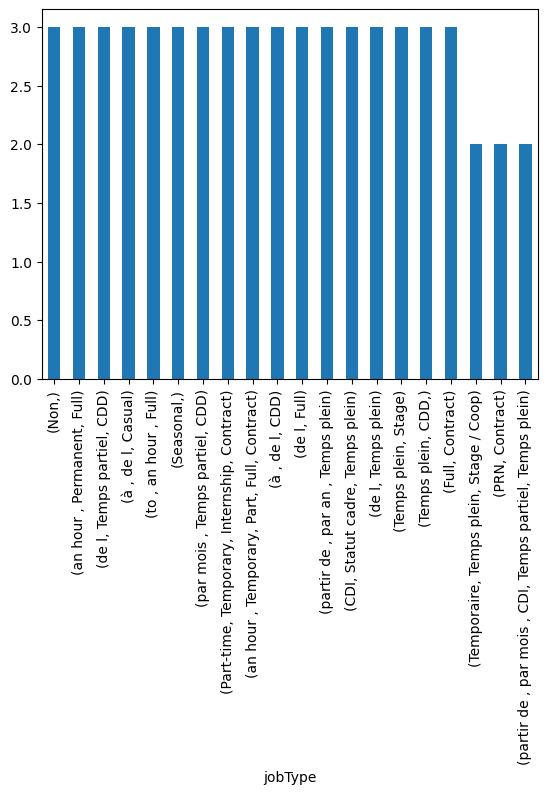

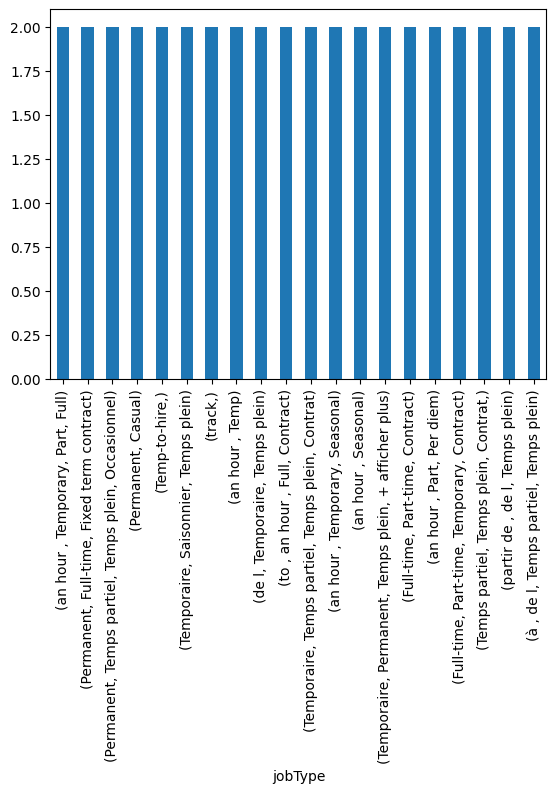

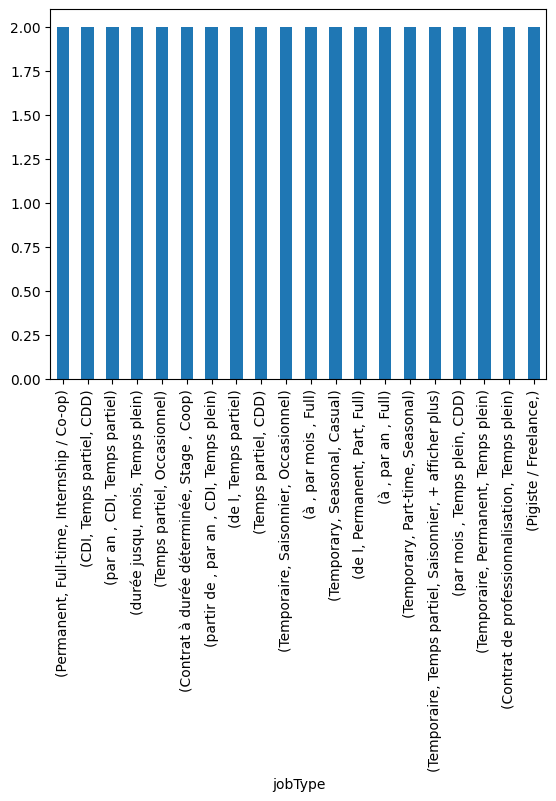

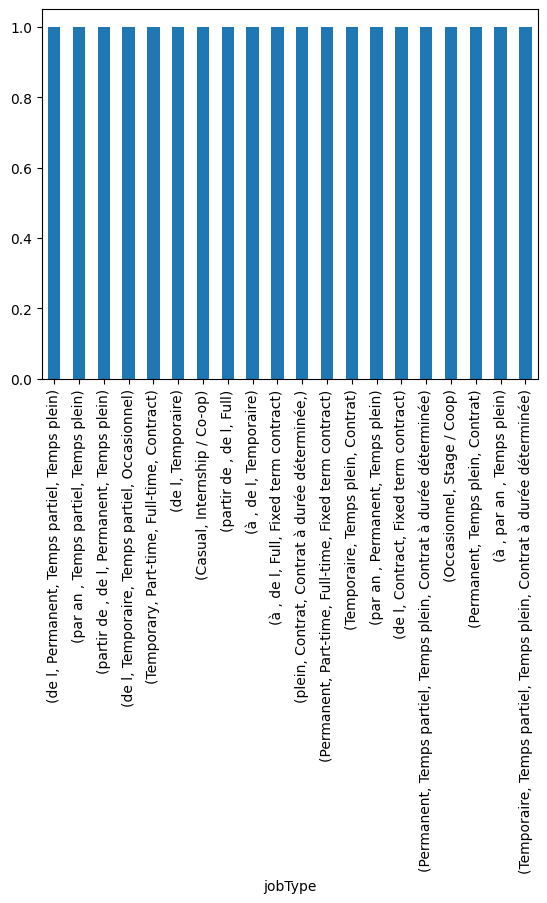

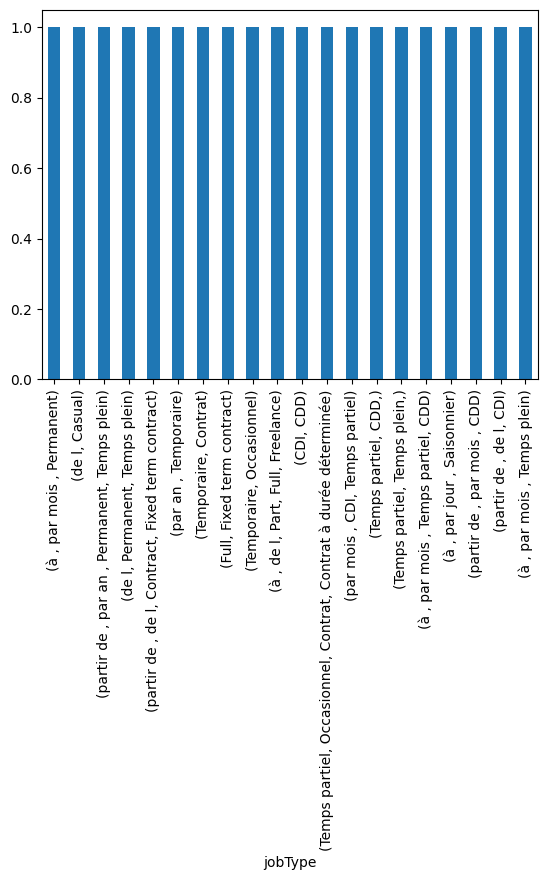

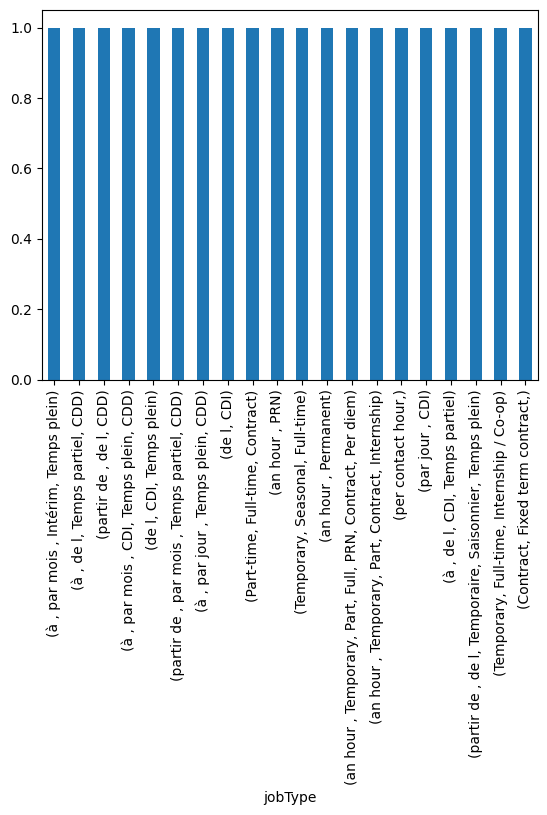

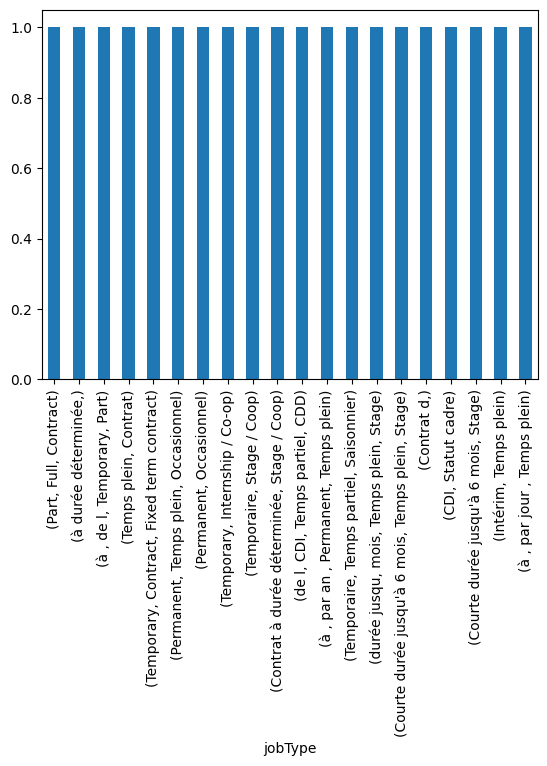

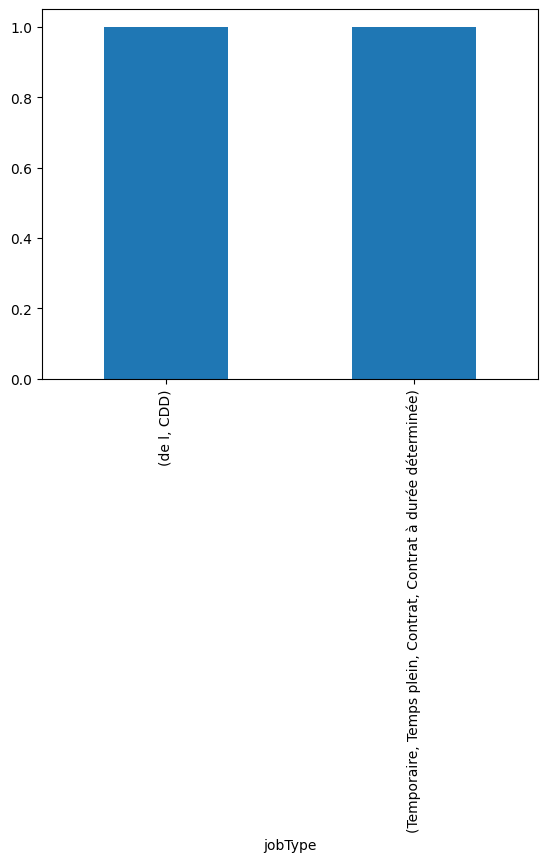

In [18]:
plot_bar_chart(df, 'jobType')

<Axes: xlabel='jobType'>

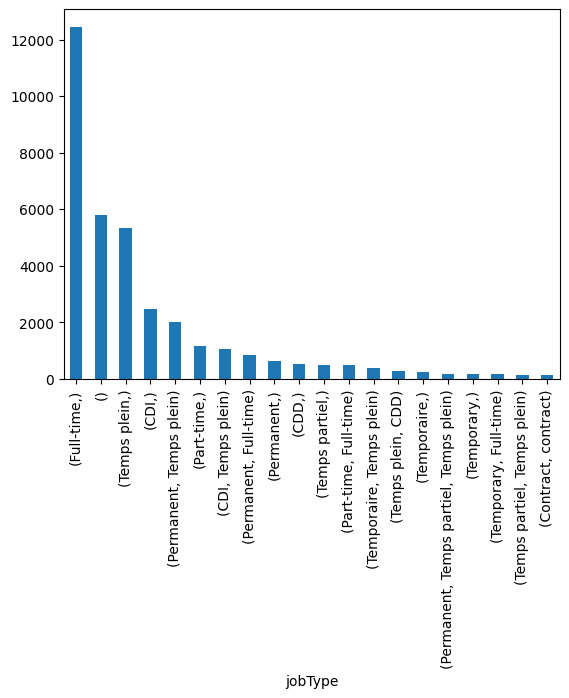

In [59]:
df_counts = df['jobType'].value_counts()[:20].plot(kind='bar')
# df_counts.plot(kind='scatter', x='positionTitle', y='location', s=df_counts['count'] * 10)
# plt.xticks(rotation=45)
# plt.show()
df_counts

<Axes: xlabel='salary'>

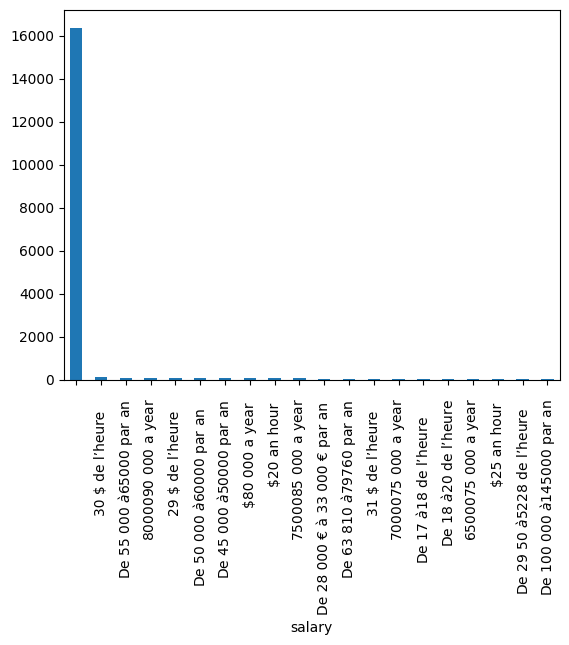

In [58]:
df['salary'] = df.apply(
    lambda x: "" 
    if not re.search(r'\d+', str(x['salary'])) 
    else x['salary'], 
    axis=1
)

# Afficher les 10 valeurs les plus fréquentes dans salary
df['salary'].value_counts()[:20].plot(kind='bar')

In [21]:
def transform_position_title(df):
    """
    This function cleans a DataFrame containing job posting information by following these steps:
    Steps:
    1. Remove dates:
    2. Remove salary rates:
    3. Remove hourly rates:
    4. Replace codes with actual position titles where possible:
    5. Rename bad encodings:
    6. Remove job type and shift/schedule information:
    7. Remove location if possible:
    Arguments:
    - df: DataFrame containing the job postings data to be cleaned.
    Returns:
    - A cleaned DataFrame according to the steps above.
    """

    # Remove dates
    date_pattern1 = r'\d{1,2}/\d{1,2}/\d{2,4}'
    date_pattern2 = r'\d{1,2}-\d{1,2}-\d{2,4}'
    date_pattern3 = r'\d{1,2}\.\d{1,2}\.\d{2,4}'
    date_pattern4 = r'\d{1,2}\s\w+\s\d{2,4}'
    date_pattern5 = r'\w+\s\d{1,2},\s\d{4}'
    date_pattern6 = r'\d{4}-\d{2}-\d{2}'
    date_patterns = [date_pattern1, date_pattern2, date_pattern3, date_pattern4, date_pattern5, date_pattern6]
    df = df.map(lambda x: re.sub(pattern, '', x) for pattern in date_patterns)

    # Remove month and year
    month_year_pattern = r'\b(janvier|january|février|february|mars|march|avril|april|mai|may|juin|june|juillet|july|août|august|septembre|september|octobre|october|novembre|november|décembre|december)\s\d{4}\b'
    df = df.map(lambda x: re.sub(month_year_pattern, '', x))

    # Remove salary rates
    pattern_salary_ca = re.compile(r'(?:De\s)?([\d\s]+)\s?\$(?:\s?à\s([\d\s]+)\s?\$\s?)(?:par\s|per\s|annuel\s|yearly\s)?(year|annum|an)\s*', re.IGNORECASE)
    pattern_salary_us = re.compile(r'(?:From\s)?\$\d+(?:,\d{3})*(?:\.\d{2})?(?:–\$\d+(?:,\d{3})*(?:\.\d{2})?)?\s?(?:a|per)\s(hour|day|week|month|year)\s*', re.IGNORECASE)
    pattern_salary_fr = re.compile(r'(?:De\s)?([\d\s]+)\s?€\s?à\s([\d\s]+)\s?€\s?(?:par\s|per\s|annuel\s|yearly\s|annum\s)?(an|year)\s*', re.IGNORECASE)
    salary_patterns = [pattern_salary_ca, pattern_salary_us, pattern_salary_fr]
    df = df.map(lambda x: re.sub(pattern, '', x) for pattern in salary_patterns)

    # Remove hourly rates
    time_units_pattern = r'\b(heure|hrs|hour|day|jour|week|semaine)\b'
    df = df.map(lambda x: re.sub(time_units_pattern, '', x))

    # Replace codes with actual position titles where possible(eg. RN -> Registered Nurse)
    
    # Rename bad encodings

    # Remove job type and shift/schedule information
    jobType_pattern = r'\b(temps\splein|full\s?time|part\s?time|temps\s?partiel|contract|contractuel|permanent|temporaire|temporary|contractual\b'
    shiftAndSchedule_pattern = r'\b(jour|day|soir|evening|nuit|night|weekend|fin\sde\ssemaine|weekend|rotating|rotatif|rotative|rotating\b'
    df = df.map(lambda x: re.sub(jobType_pattern, '', x))
    df = df.map(lambda x: re.sub(shiftAndSchedule_pattern, '', x))

    # Remove location if possible
    


    
    return df


In [57]:

def transform_salary_and_job_type(df): # ===> Betch
    """
    This function processes salary and job type information in a DataFrame, ensuring consistency in language and data structure, following these steps:
    Steps:
    1. Extract salary information from combined fields:
    2. Handle missing salary information:
    3. Standardize hybrid data (language and format)
    4. Detect and translate language:
    Arguments:
    - df: DataFrame containing job posting data with salary, job type, and schedule information to be processed.
    Returns:
    - A cleaned DataFrame with standardized salary, job type, schedule, and translated information where necessary.
    """
    jobType_pattern = r"\b(temps[-\s]plein|full[-\s]time|part[-\s]time|temps[-\s]partiel|contract|contractuel|permanent|temporaire|temporary|contractual|CDI|CDD|Stage\\Coop)\b"
    salary_df= df['salaryInfoAndJobType'].map(lambda x: re.sub(jobType_pattern, '', x, flags=re.IGNORECASE))
    jobType_df = df['salaryInfoAndJobType'].map(lambda x: re.findall(jobType_pattern,x, flags=re.IGNORECASE))
    salary_df = salary_df.map(lambda x: re.sub(r'[-\s?,]', ' ', x))
    jobType_df=jobType_df.map(lambda x: tuple(x) if isinstance(x, list) else x)
    return salary_df, jobType_df

result = transform_salary_and_job_type(df)
# print(result[1])
df['salary'] = np.where(df['salary'].isna() | (df['salary'] == ''), result[0], df['salary'])
df['jobType'] = np.where(df['jobType'].isna() | (df['jobType'] == ''), result[1], df['jobType'])

In [ ]:
# Vérifier pour une mauvaise encodage
import chardet
def detect_encoding_issues(text):
    """
    This function detects encoding issues in a text field by attempting to encode and decode the text using UTF-8.
    Arguments:
    - text: Text field to be checked for encoding issues.
    Returns:
    - A boolean value indicating whether encoding issues were detected in the text field.
    - False if no encoding issues were detected, True otherwise.
    """
    try:
        text.encode('utf-8').decode('utf-8')
        return False 
    except UnicodeDecodeError:
        return True
    
def correct_bad_encoding(text):
    """
    This function corrects bad encoding in a text field by removing or replacing invalid characters.
    Arguments:
    - text: Text field containing bad encoding to be corrected.
    Returns:
    - A cleaned text field with bad encoding removed or replaced.
    """
    # detect encoding 
    default_text = text
    correct_encode = chardet.detect(text)['encoding']
    if correct_encode is not None:
        text = text.decode(correct_encode)
    if detect_encoding_issues(text):
        return default_text.encode('utf-8', 'replace').decode('utf-8')
    else:
        return text.encode('utf-8').decode('utf-8')

def transform_company_name(df): # ===> Yousra
    """
    This function cleans a DataFrame by identifying and removing bad encodings, specifically sequences of squares or other invalid characters in text fields (e.g., names).

    Steps:
    1. Detect bad encodings:
    2. Remove or replace bad encodings:

    Arguments:
    - df: DataFrame containing text fields where bad encodings (e.g., sequences of squares) need to be removed.

    Returns:
    - A cleaned DataFrame with bad encodings removed from text fields.


    """
    company_name_df = df['companyName']
    company_name_df = company_name_df.map(  lambda x: correct_bad_encoding(x) if detect_encoding_issues(x) else x)
    return company_name_df

df['companyName'] = transform_company_name(df)


In [ ]:
def transform_location(df):  # ===> Dan 
    """
    This function cleans a DataFrame by removing special characters, specifically at the beginning of text fields, and addressing bad encodings.

    Steps:
    1. Remove bad encodings:
    2. Remove special characters at the beginning of text fields:

    Arguments:
    - df: DataFrame containing text fields where bad encodings and special characters at the beginning of strings need to be removed.

    Returns:
    - A cleaned DataFrame with special characters removed from the beginnings of text fields and bad encodings corrected.
    """
    location_df = df['location']
    location_df = location_df.map(  lambda x: correct_bad_encoding(x) if detect_encoding_issues(x) else x)
    return location_df

df['location'] = transform_company_name(df)

In [ ]:
def transfrom(x):
    x['positionTitle']=transform_position_title(x)
    result = transform_salary_and_job_type(x)
    x['salary'] = np.where(x['salary'].isna() | (x['salary'] == ''), result[0], x['salary'])
    x['jobType'] = np.where(x['jobType'].isna() | (x['jobType'] == ''), result[1], x['jobType'])
    x['companyName']=transform_company_name(x)
    x['location']=transform_location(x)

In [ ]:
plot_bar_chart(df, 'positionTitle')

#### We can see that salaries are too different we can try to put them together in intervals